In [115]:
import csv
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 
import json

import landmarks_utils
import dataset_utils
import process_heartrate as utils
from importlib import reload

video_dir = "dataset/videos/"
csv_path = "dataset/dataset.csv"
landmarks_path = "dataset/outputs/landmarks/"
datastreams_path = "dataset/outputs/datastreams/"
frames_path = "dataset/outputs/frames/"
face_pose_path = "dataset/outputs/face_pose/"


fields, rows = dataset_utils.open_csv(csv_path)
reload(utils)

<module 'process_heartrate' from '/Users/dannydu/Documents/2. Research/2. COVID Video Project/4. Work/10. Final/process_heartrate.py'>

In [122]:
reload(utils)

hr_lists = []
hr_medians = []
samples = []

for filename in os.listdir(face_pose_path):
    if filename.find(".json") == -1: continue
    index = int(filename[:-5])
    samples.append(index)
        
    fps = float(rows[index][fields.vid_fps])
    signal_1d = np.load(datastreams_path+str(index)+"/signal_1D.npy")
    signal_3d = np.load(datastreams_path+str(index)+"/signal_3D.npy")
    
    f = open(face_pose_path+filename)
    pose_dict = json.loads(f.read())
    pose_vectors = [pose_dict[k] for k in pose_dict]
    
    hr_best_fft = utils.process_sliding_window(signal_1d, fps, 5, 5, utils.process_fft, "best", filter=True,best_n=5, pose_vectors=pose_vectors)
    hr_best_pos = utils.process_sliding_window(signal_3d, fps, 5, 5, utils.process_pos, "best",best_n=5, pose_vectors=pose_vectors)
    
    rows[index][fields.best_fft_filtered] = str(hr_best_fft * 60)
    rows[index][fields.best_pos] = str(hr_best_pos * 60)
    

In [123]:
dataset_utils.write_csv(csv_path, rows)

In [124]:
gt = np.array([float(rows[i][fields.adjusted_hr_bpm]) for i in samples])
pos = np.array([float(rows[i][fields.hr_pos]) for i in samples])
fft_filtered = np.array([float(rows[i][fields.hr_fft_filtered]) for i in samples])
median_pos = np.array([float(rows[i][fields.median_pos]) for i in samples])
median_fft_filtered = np.array([float(rows[i][fields.median_fft_filtered]) for i in samples])
best_pos = np.array([float(rows[i][fields.best_pos]) for i in samples])
best_fft_filtered = np.array([float(rows[i][fields.best_fft_filtered]) for i in samples])

wechat_compression = np.array([rows[i][fields.wechat_compression]=='Y' for i in samples])

rmse_pos = utils.calculate_rmse(gt, pos)
rmse_fft_filtered = utils.calculate_rmse(gt, fft_filtered)
rmse_median_pos = utils.calculate_rmse(gt, median_pos)
rmse_median_fft_filtered = utils.calculate_rmse(gt, median_fft_filtered)
rmse_best_pos = utils.calculate_rmse(gt, best_pos)
rmse_best_fft_filtered = utils.calculate_rmse(gt, best_fft_filtered)

print("rmse_pos: ", rmse_pos)
print("rmse_fft_filtered: ", rmse_fft_filtered)
print("rmse_median_pos: ", rmse_median_pos)
print("rmse_median_fft_filtered: ", rmse_median_fft_filtered)
print("rmse_best_pos: ", rmse_best_pos)
print("rmse_best_fft_filtered: ", rmse_best_fft_filtered)

rmse_pos:  21.255697983069126
rmse_fft_filtered:  34.76393909608984
rmse_median_pos:  21.293595980003655
rmse_median_fft_filtered:  18.844874526267414
rmse_best_pos:  17.11081890071881
rmse_best_fft_filtered:  24.307099185418505


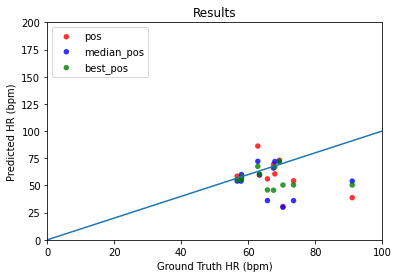

In [85]:
preds = (pos, median_pos, best_pos)
colors = ("red", "blue", "green")
groups = ("pos", "median_pos", "best_pos")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

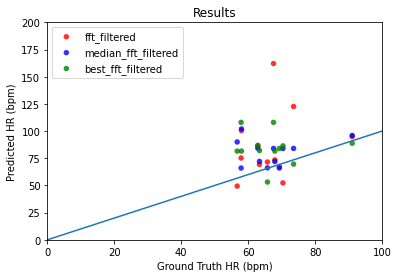

In [86]:
preds = (fft_filtered, median_fft_filtered, best_fft_filtered)
colors = ("red", "blue", "green")
groups = ("fft_filtered", "median_fft_filtered", "best_fft_filtered")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

In [119]:
samples = np.array(samples)[wechat_compression==False]
gt = np.array([float(rows[i][fields.adjusted_hr_bpm]) for i in samples])
pos = np.array([float(rows[i][fields.hr_pos]) for i in samples])
fft_filtered = np.array([float(rows[i][fields.hr_fft_filtered]) for i in samples])
median_pos = np.array([float(rows[i][fields.median_pos]) for i in samples])
median_fft_filtered = np.array([float(rows[i][fields.median_fft_filtered]) for i in samples])
best_pos = np.array([float(rows[i][fields.best_pos]) for i in samples])
best_fft_filtered = np.array([float(rows[i][fields.best_fft_filtered]) for i in samples])

rmse_pos = utils.calculate_rmse(gt, pos)
rmse_fft_filtered = utils.calculate_rmse(gt, fft_filtered)
rmse_median_pos = utils.calculate_rmse(gt, median_pos)
rmse_median_fft_filtered = utils.calculate_rmse(gt, median_fft_filtered)
rmse_best_pos = utils.calculate_rmse(gt, best_pos)
rmse_best_fft_filtered = utils.calculate_rmse(gt, best_fft_filtered)

print("rmse_pos: ", rmse_pos)
print("rmse_fft_filtered: ", rmse_fft_filtered)
print("rmse_median_pos: ", rmse_median_pos)
print("rmse_median_fft_filtered: ", rmse_median_fft_filtered)
print("rmse_best_pos: ", rmse_best_pos)
print("rmse_best_fft_filtered: ", rmse_best_fft_filtered)

rmse_pos:  9.579285234111058
rmse_fft_filtered:  18.747042022285196
rmse_median_pos:  11.327740151671849
rmse_median_fft_filtered:  21.42120002071009
rmse_best_pos:  7.450806579165955
rmse_best_fft_filtered:  25.43993206308518


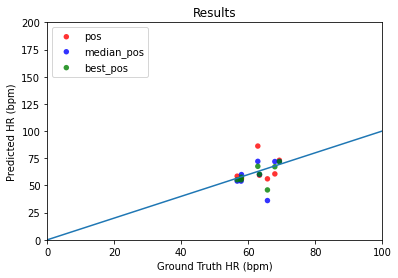

In [120]:
preds = (pos, median_pos, best_pos)
colors = ("red", "blue", "green")
groups = ("pos", "median_pos", "best_pos")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

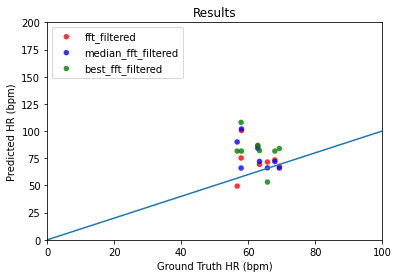

In [121]:
preds = (fft_filtered, median_fft_filtered, best_fft_filtered)
colors = ("red", "blue", "green")
groups = ("fft_filtered", "median_fft_filtered", "best_fft_filtered")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

In [125]:
samples = np.array(samples)[wechat_compression==True]
gt = np.array([float(rows[i][fields.adjusted_hr_bpm]) for i in samples])
pos = np.array([float(rows[i][fields.hr_pos]) for i in samples])
fft_filtered = np.array([float(rows[i][fields.hr_fft_filtered]) for i in samples])
median_pos = np.array([float(rows[i][fields.median_pos]) for i in samples])
median_fft_filtered = np.array([float(rows[i][fields.median_fft_filtered]) for i in samples])
best_pos = np.array([float(rows[i][fields.best_pos]) for i in samples])
best_fft_filtered = np.array([float(rows[i][fields.best_fft_filtered]) for i in samples])

rmse_pos = utils.calculate_rmse(gt, pos)
rmse_fft_filtered = utils.calculate_rmse(gt, fft_filtered)
rmse_median_pos = utils.calculate_rmse(gt, median_pos)
rmse_median_fft_filtered = utils.calculate_rmse(gt, median_fft_filtered)
rmse_best_pos = utils.calculate_rmse(gt, best_pos)
rmse_best_fft_filtered = utils.calculate_rmse(gt, best_fft_filtered)

print("rmse_pos: ", rmse_pos)
print("rmse_fft_filtered: ", rmse_fft_filtered)
print("rmse_median_pos: ", rmse_median_pos)
print("rmse_median_fft_filtered: ", rmse_median_fft_filtered)
print("rmse_best_pos: ", rmse_best_pos)
print("rmse_best_fft_filtered: ", rmse_best_fft_filtered)

rmse_pos:  34.23285963879487
rmse_fft_filtered:  54.06192019582062
rmse_median_pos:  33.22072087404616
rmse_median_fft_filtered:  12.151224920877231
rmse_best_pos:  27.700385069513082
rmse_best_fft_filtered:  21.866067906245515


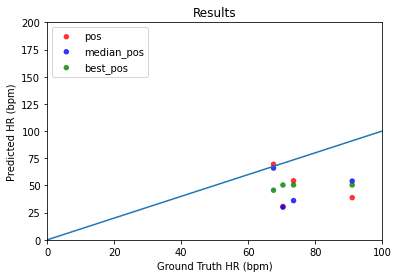

In [126]:
preds = (pos, median_pos, best_pos)
colors = ("red", "blue", "green")
groups = ("pos", "median_pos", "best_pos")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

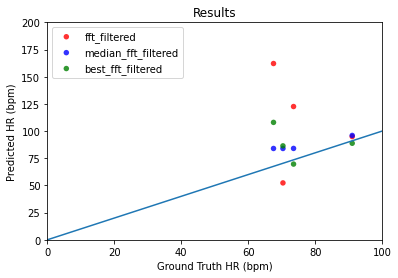

In [127]:
preds = (fft_filtered, median_fft_filtered, best_fft_filtered)
colors = ("red", "blue", "green")
groups = ("fft_filtered", "median_fft_filtered", "best_fft_filtered")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 100), ylim=(0, 200))
ax.plot((0,100), (0,100))
plt.xlabel('Ground Truth HR (bpm)')
plt.ylabel('Predicted HR (bpm)')

i=1
for color,group,pred in zip(colors,groups,preds):
    ax.scatter(gt, pred, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Results')
plt.legend(loc=2)
plt.show()
plt.close()

In [104]:
pos_best = np.argsort(np.abs(gt-rmse_best_pos))
fft_best = np.argsort(np.abs(gt-rmse_median_fft_filtered))

In [105]:
pos_best

array([11,  9,  4,  2,  1,  8, 10,  7,  0,  3,  6,  5])

In [106]:
fft_best

array([11,  9,  4,  2,  1,  8, 10,  7,  0,  3,  6,  5])

9


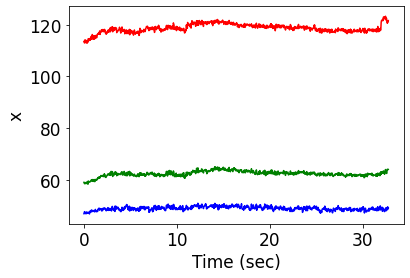

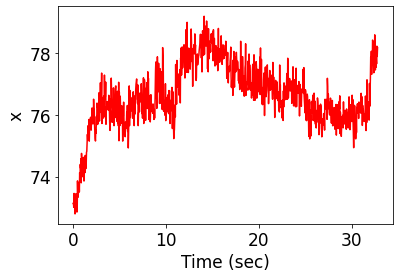

In [114]:
print(samples[11])

signal_1d = np.load(datastreams_path+str(samples[11])+"/signal_1D.npy")
signal_3d = np.load(datastreams_path+str(samples[11])+"/signal_3D.npy")

utils.plotSignals_3D(signal_3d, 30, 'x')
utils.plotSignals_1D(signal_1d, 30, 'x')

11


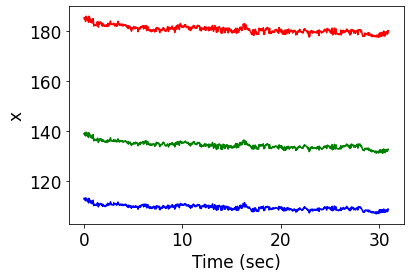

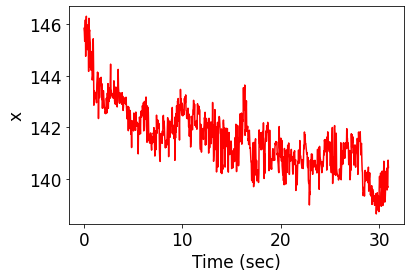

In [113]:
print(samples[5])
signal_1d = np.load(datastreams_path+str(samples[5])+"/signal_1D.npy")
signal_3d = np.load(datastreams_path+str(samples[5])+"/signal_3D.npy")

utils.plotSignals_3D(signal_3d, 30, 'x')
utils.plotSignals_1D(signal_1d, 30, 'x')